<a href="https://colab.research.google.com/github/urvesh2012/MLTSA25_UBhagat/blob/main/HW7/autoencoder_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder for time series
an autoencoder is a deep neural network that reproduces input data

it does so by progressively shrinking the size of the layers from the input size to a bottle neck and then expanding them back progressively to the initial size

note: the input and target are the same!

put your imports in the top cell

In [1]:
#Deep leaarning imports
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import glob
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


get the data by cloaning the repo https://github.com/nlandolfi/acc2022treelinearcascades_stocks.git

In [2]:
# These are stock price time series. Use the " Volume" column as your chosen time series

In [3]:
!git clone https://github.com/nlandolfi/acc2022treelinearcascades_stocks.git

Cloning into 'acc2022treelinearcascades_stocks'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 40 (delta 0), reused 40 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 1.25 MiB | 7.07 MiB/s, done.


In [4]:
ls

acc2022treelinearcascades_stocks/  sample_data/


In [5]:
ls acc2022treelinearcascades_stocks/data

aapl.csv  cat.csv   dis.csv  hon.csv   jpm.csv  mrk.csv   trv.csv  wba.csv
amgn.csv  crm.csv   dow.csv  ibm.csv   ko.csv   msft.csv  unh.csv  wmt.csv
axp.csv   csco.csv  gs.csv   intc.csv  mcd.csv  nke.csv   v.csv
ba.csv    cvx.csv   hd.csv   jnj.csv   mmm.csv  pg.csv    vz.csv


check that all files have the same length. The system command `wc -l returns` the  number of lines (stands for "word count -lines")

In [6]:
!wc -l acc2022treelinearcascades_stocks/data/*

   2516 acc2022treelinearcascades_stocks/data/aapl.csv
   2516 acc2022treelinearcascades_stocks/data/amgn.csv
   2516 acc2022treelinearcascades_stocks/data/axp.csv
   2516 acc2022treelinearcascades_stocks/data/ba.csv
   2516 acc2022treelinearcascades_stocks/data/cat.csv
   2516 acc2022treelinearcascades_stocks/data/crm.csv
   2516 acc2022treelinearcascades_stocks/data/csco.csv
   2516 acc2022treelinearcascades_stocks/data/cvx.csv
   2516 acc2022treelinearcascades_stocks/data/dis.csv
    542 acc2022treelinearcascades_stocks/data/dow.csv
   2516 acc2022treelinearcascades_stocks/data/gs.csv
   2516 acc2022treelinearcascades_stocks/data/hd.csv
   2516 acc2022treelinearcascades_stocks/data/hon.csv
   2516 acc2022treelinearcascades_stocks/data/ibm.csv
   2516 acc2022treelinearcascades_stocks/data/intc.csv
   2516 acc2022treelinearcascades_stocks/data/jnj.csv
   2516 acc2022treelinearcascades_stocks/data/jpm.csv
   2516 acc2022treelinearcascades_stocks/data/ko.csv
   2516 acc2022treelinearcas

In [7]:
#create a list of all files you want to load
files = glob.glob("acc2022treelinearcascades_stocks/data/*")

In [8]:
num_timepoints = sum(1 for line in open(files[0])) - 1

data = np.zeros((len(files), num_timepoints))

 read in all the data into the array

In [9]:
# for i, f in tqdm(enumerate(files), total=len(files)):
#     df = pd.read_csv(f)
#     data[i, :] = df[" Volume"].values

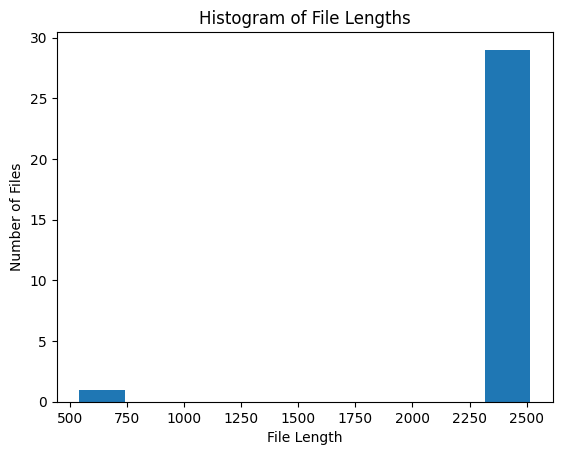

In [10]:
# prompt: Plot a histogram of length of the files.

import matplotlib.pyplot as plt
import glob

# Assuming 'files' list is already populated from the previous code
files = glob.glob("acc2022treelinearcascades_stocks/data/*")

file_lengths = []
for file in files:
    with open(file) as f:
        file_lengths.append(sum(1 for _ in f) -1) # Subtract 1 to exclude the header


plt.hist(file_lengths, bins=10) # Adjust the number of bins as needed
plt.xlabel("File Length")
plt.ylabel("Number of Files")
plt.title("Histogram of File Lengths")
plt.show()


**Figure 1**

In [11]:
# prompt: Make a list of the files with length less than 2516.

# Assuming 'files' list and 'file_lengths' list are already populated from the previous code
short_files = [files[i] for i, length in enumerate(file_lengths) if length < 2516]
short_files


['acc2022treelinearcascades_stocks/data/dow.csv']

In [12]:
# prompt: Remove all the files from the larger set that are in the short_files subset.

# Assuming 'files' list and 'short_files' list are already populated from the previous code

# Convert short_files to a set for faster lookups
short_files_set = set(short_files)

# Use list comprehension to create a new list containing only files NOT in short_files
remaining_files = [file for file in files if file not in short_files_set]

print(f"Number of files initially: {len(files)}")
print(f"Number of short files: {len(short_files)}")
print(f"Number of remaining files: {len(remaining_files)}")


Number of files initially: 30
Number of short files: 1
Number of remaining files: 29


In [13]:
for i, f in enumerate(remaining_files):
    df = pd.read_csv(f)
    data[i, :] = df[" Volume"].values

plot the time series

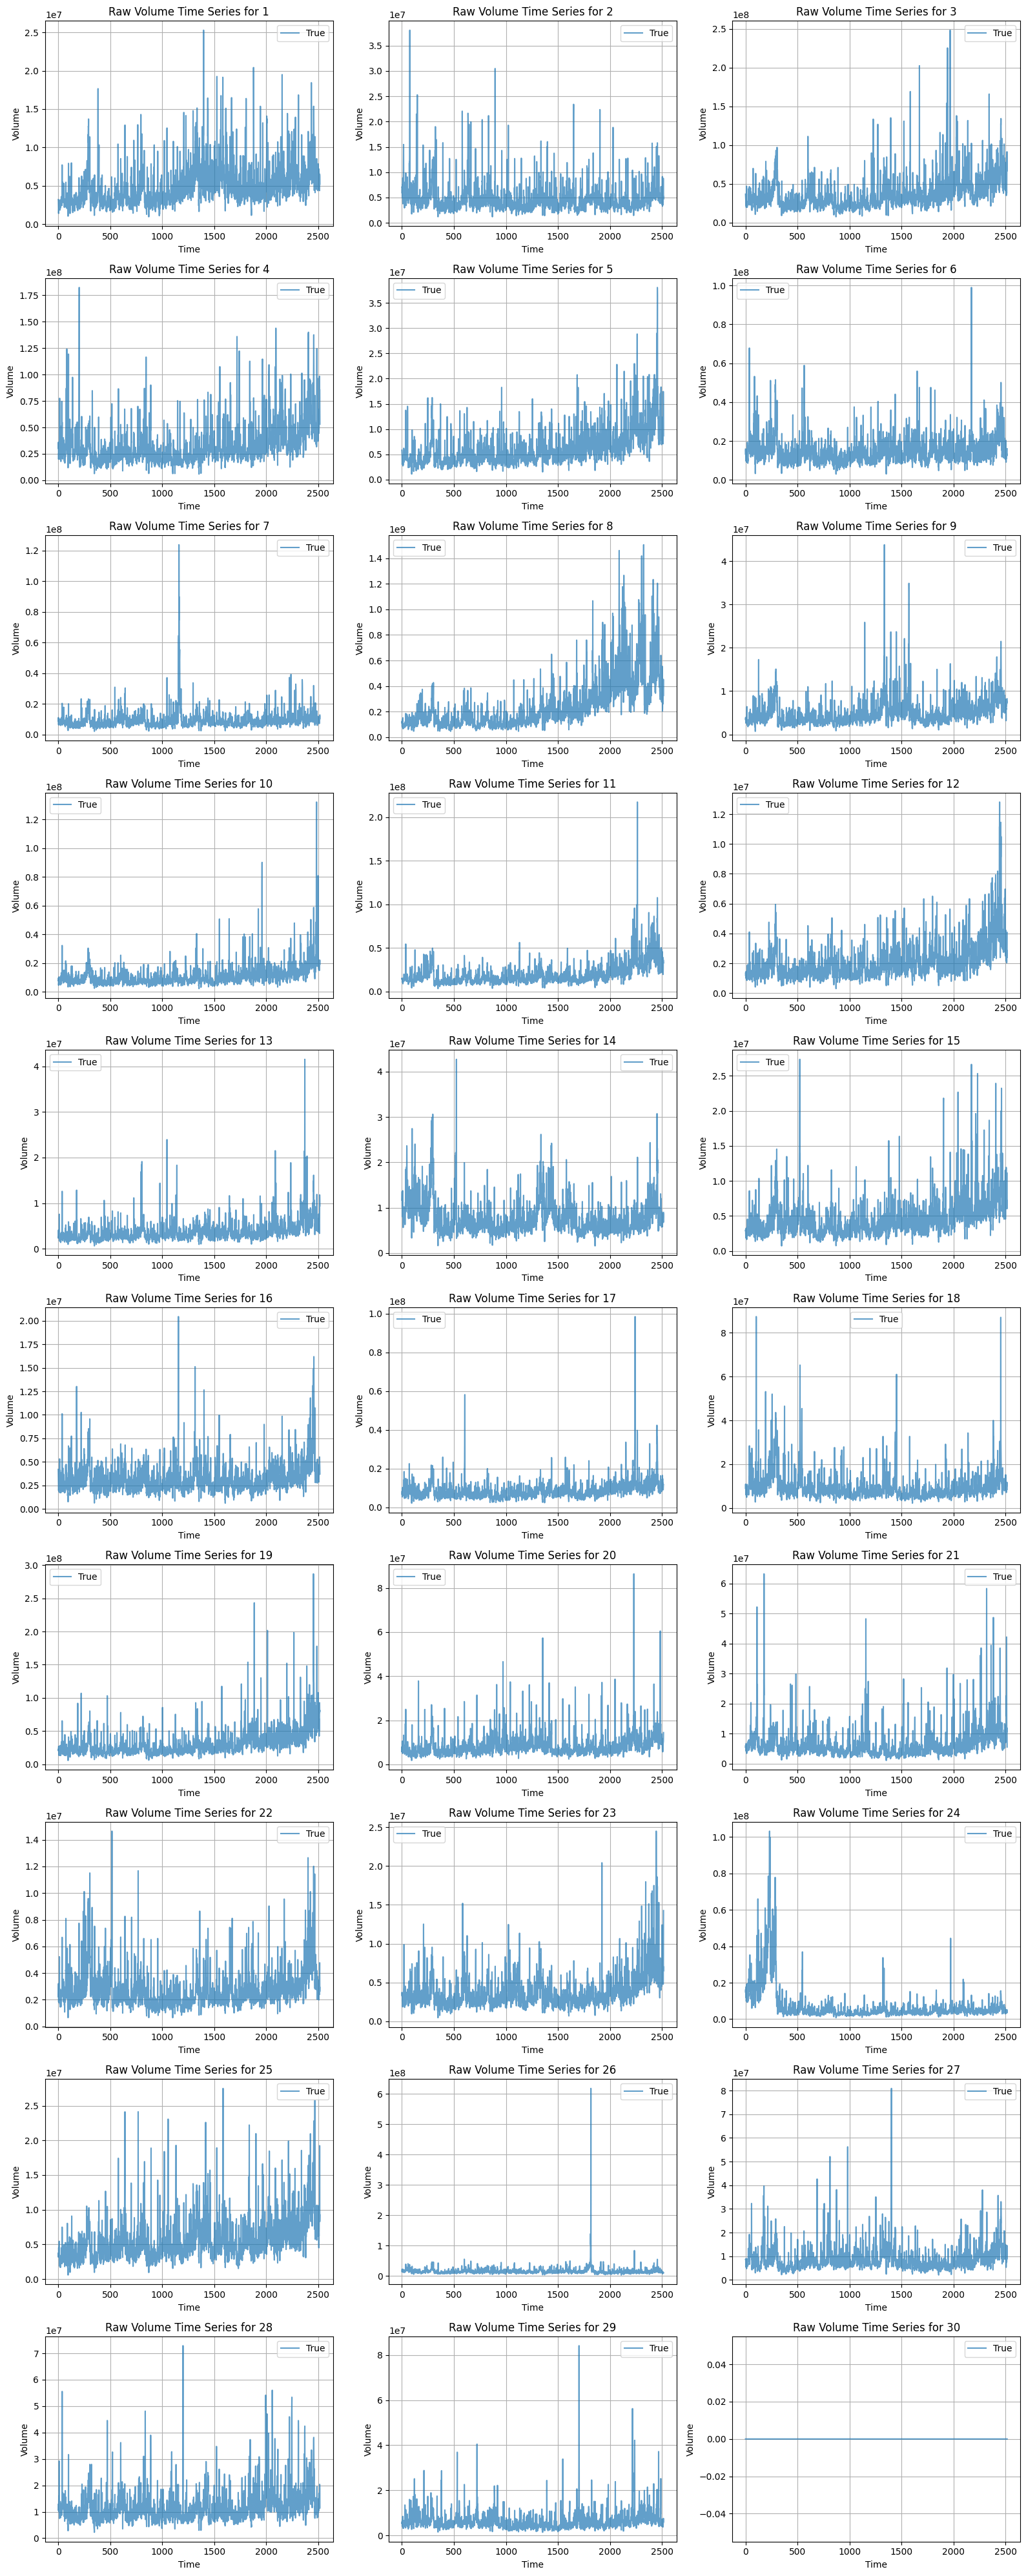

In [14]:
num_data = data.shape[0]
cols = 3
rows = math.ceil(num_data / cols)

plt.figure(figsize=(16, 4 * rows))

for i in range(num_data):
    plt.subplot(rows, cols, i + 1)
    plt.plot(data[i], label='True', alpha=0.7)
    plt.title(f'Raw Volume Time Series for {i + 1}')
    plt.xlabel("Time")
    plt.ylabel("Volume")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


**Figure 2**

scale the time series appropriately
hint: use Standard Scaler to save the mean and standard deviation of each time series, that way you can apply them later to your predicted results

In [15]:
# Initialize containers
scalers = []
scaled_data = np.zeros_like(data)

# Scale each time series (row) independently
for i in range(data.shape[0]):
    scaler = StandardScaler()
    scaled_data[i, :] = scaler.fit_transform(data[i].reshape(-1, 1)).flatten()
    scalers.append(scaler)  # store scaler for inverse_transform later

print(scaler.mean_)


[0.]


In [16]:
scaled_data.mean(axis=1)

array([-1.35556643e-16,  2.54168705e-17, -1.12963869e-16,  4.51855476e-17,
       -9.03710952e-17,  3.38891607e-17,  5.36578378e-17,  1.35556643e-16,
       -4.51855476e-17, -9.03710952e-17, -9.03710952e-17,  9.03710952e-17,
       -1.12963869e-16,  2.25927738e-17,  1.58149417e-16, -1.12963869e-17,
        9.03710952e-17, -6.21301279e-17, -4.51855476e-17, -6.77783214e-17,
        0.00000000e+00,  1.58149417e-16, -6.77783214e-17,  0.00000000e+00,
       -6.77783214e-17,  7.20144665e-17,  8.47229017e-17, -9.03710952e-17,
        7.90747083e-17,  0.00000000e+00])

In [17]:
scaled_data.std(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

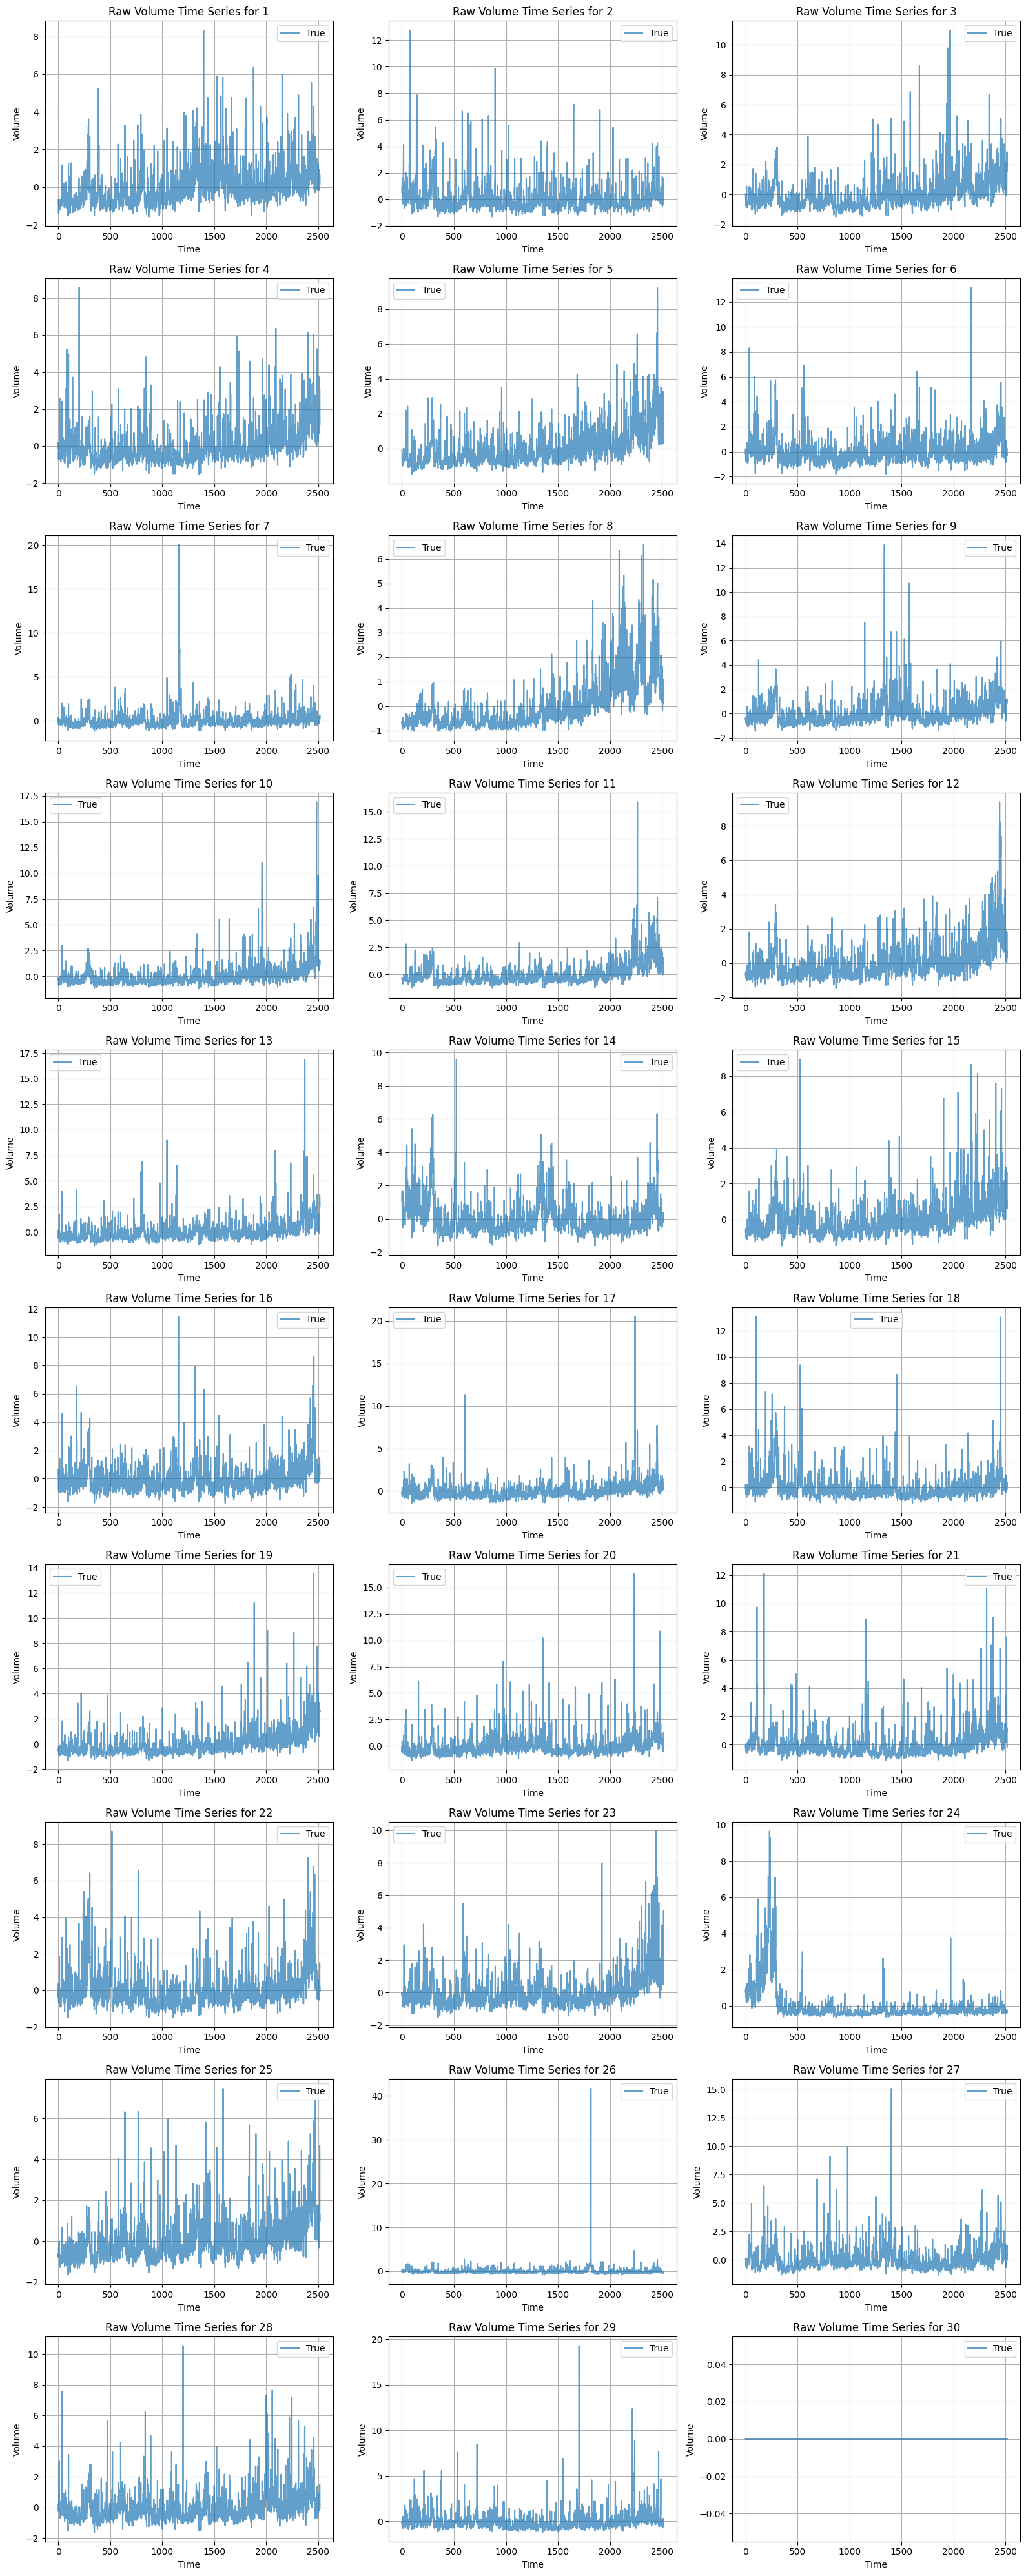

In [18]:
num_data = scaled_data.shape[0]
cols = 3
rows = math.ceil(num_data / cols)

plt.figure(figsize=(16, 4 * rows))

for i in range(num_data):
    plt.subplot(rows, cols, i + 1)
    plt.plot(scaled_data[i], label='True', alpha=0.7)
    plt.title(f'Raw Volume Time Series for {i + 1}')
    plt.xlabel("Time")
    plt.ylabel("Volume")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


**Figure 3**

split traiing and testimg data

In [19]:
# Split stock-wise: 80% train stocks, 20% test stocks
num_series = scaled_data.shape[0]
split_idx = int(num_series * 0.8)

X_train = scaled_data[:split_idx]
X_test = scaled_data[split_idx:]

# Since it's an autoencoder, targets = inputs
y_train = X_train.copy()
y_test = X_test.copy()

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24, 2516), (6, 2516), (24, 2516), (6, 2516))

build the model. It shoudl be a MLP (Multi Layer Perceptron) thus the only kind of layers you need are Dense layers (`from keras.layers import Dense`). Keep in mind the size of the initial time series. By definition a autoencoder will start with large layers, shdink the number of neurons in each layer progressively till a "bottle neck" layer (e.g. 32 neurons, but try what works). then add progressively larger layers until the last layer has the same size as the imput data. Use `relu` activation functions for all layers but the last one, which shoudl be `linear`

In [21]:
input_size = X_train.shape[1]
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(input_size,)))
# model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
# model.add(Dense(256, activation='sigmoid'))
model.add(Dense(input_size, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# this is a call back that ensures you stop training when the validation loss stops improving (es)
# ad saves the model if it is better than the model at the previous training epoch (mc)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


write the `model.compile` command passing to the compile function the `adam` optimizer and `mean_squared_error` loss function

```model.compile(...```


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       644,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2516)           │       324,564 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,580 (3.90 MB)

 Trainable params: 1,022,580 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

write the model.fit command. This will start the training of the neural network.
pass to the fit() function the following arguments:
- the imput data: that is your data train pd.array
- the desired output.... pay attention! this is an autoencoder so it should reproduce with fidelity the input data!
- create an internal validation set: this will split the training data so that at each epoch you can assess the model performance on unseen data `validation_split=0.1`
- set up training for 200 epochs with the `epoch=200` argument
- set the `batch_size`. I set it to 10, you can try different things. Larger batch makes a faster code the has higher risk of overfitting
- set `verbose=1`
- add the callbacks with `callbacks=[es, mc]


```training = model.fit(.....```



In [25]:
training = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=10,
    verbose=1,
    callbacks=[es, mc]
)

Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 1.0061
Epoch 1: val_loss improved from inf to 0.97406, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 1.0020 - val_loss: 0.9741
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9648
Epoch 2: val_loss improved from 0.97406 to 0.88742, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.9507 - val_loss: 0.8874
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.8418
Epoch 3: val_loss improved from 0.88742 to 0.80908, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.8420 - val_loss: 0.8091
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.7389
Epoch 4: val_loss improved from 0.80908 to 0.75379, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7448 - val_loss: 0.7538
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7269
Epoch 5: val_loss improved from 0.75379 to 0.72249, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.7025 - val_loss: 0.7225
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6431
Epoch 6: val_loss improved from 0.72249 to 0.71263, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.6554 - val_loss: 0.7126
Epoch 7/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.6349
Epoch 7: val_loss improved from 0.71263 to 0.70634, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.6410 - val_loss: 0.7063
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6333
Epoch 8: val_loss improved from 0.70634 to 0.70415, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6298 - val_loss: 0.7041
Epoch 9/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5778
Epoch 9: val_loss improved from 0.70415 to 0.69521, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.6091 - val_loss: 0.6952
Epoch 10/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5774
Epoch 10: val_loss improved from 0.69521 to 0.68762, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.5939 - val_loss: 0.6876
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.5974
Epoch 11: val_loss improved from 0.68762 to 0.68340, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5925 - val_loss: 0.6834
Epoch 12/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5804
Epoch 12: val_loss improved from 0.68340 to 0.67133, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.5739 - val_loss: 0.6713
Epoch 13/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5827
Epoch 13: val_loss improved from 0.67133 to 0.66279, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5636 - val_loss: 0.6628
Epoch 14/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.5381
Epoch 14: val_loss improved from 0.66279 to 0.64881, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.5392 - val_loss: 0.6488
Epoch 15/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5610
Epoch 15: val_loss improved from 0.64881 to 0.63822, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.5347 - val_loss: 0.6382
Epoch 16/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.5436
Epoch 16: val_loss improved from 0.63822 to 0.62762, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.5211 - val_loss: 0.6276
Epoch 17/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.4609
Epoch 17: val_loss improved from 0.62762 to 0.61767, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4883 - val_loss: 0.6177
Epoch 18/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5120
Epoch 18: val_loss improved from 0.61767 to 0.61568, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4928 - val_loss: 0.6157
Epoch 19/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4267
Epoch 19: val_loss improved from 0.61568 to 0.61271, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.4613 - val_loss: 0.6127
Epoch 20/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4750
Epoch 20: val_loss improved from 0.61271 to 0.60404, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4617 - val_loss: 0.6040
Epoch 21/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4682
Epoch 21: val_loss did not improve from 0.60404
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4483 - val_loss: 0.6065
Epoch 22/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.4450
Epoch 22: val_loss did not improve from 0.60404
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.4331 - val_loss: 0.6072
Epoch 23/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4078
Epoch 23: val_loss did not improve from 0.60404
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4105 - val_loss: 0.6127
Epoch 24/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3854
Epoch 24: val_loss did not improve from 0.60404
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3964 - val_loss: 0.6111
Epoch 25/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3555
Epoch 25: val_loss did not improve from 0.60404
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3756 - val_loss: 0.609

In [26]:
training.history.keys() # this stores the value of the loss at each epoch so you can plot it

dict_keys(['loss', 'val_loss'])

plot the loss function!!

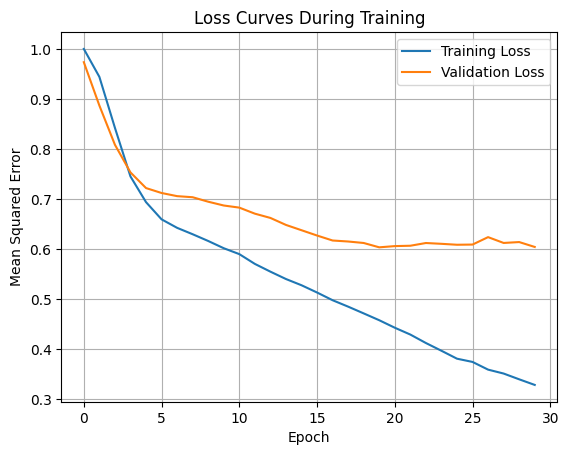

In [27]:
# Plot the loss history
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


**Figure 4:**
As shown in the plot, both the training and validation loss gradually decrease as the number of epochs increases, which is expected. However, the rate of improvement slows down over time. Around the 15th epoch, the training loss levels off, while the validation loss starts to fluctuate, suggesting that continuing training beyond this point may not lead to meaningful performance gains. Interestingly, throughout the entire training process, the validation loss remains lower than the training loss—an unusual but notable outcome.



plot (visualize) the prediction and the ground truth for the test data. What do you see? where is the model succesful where is it not?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


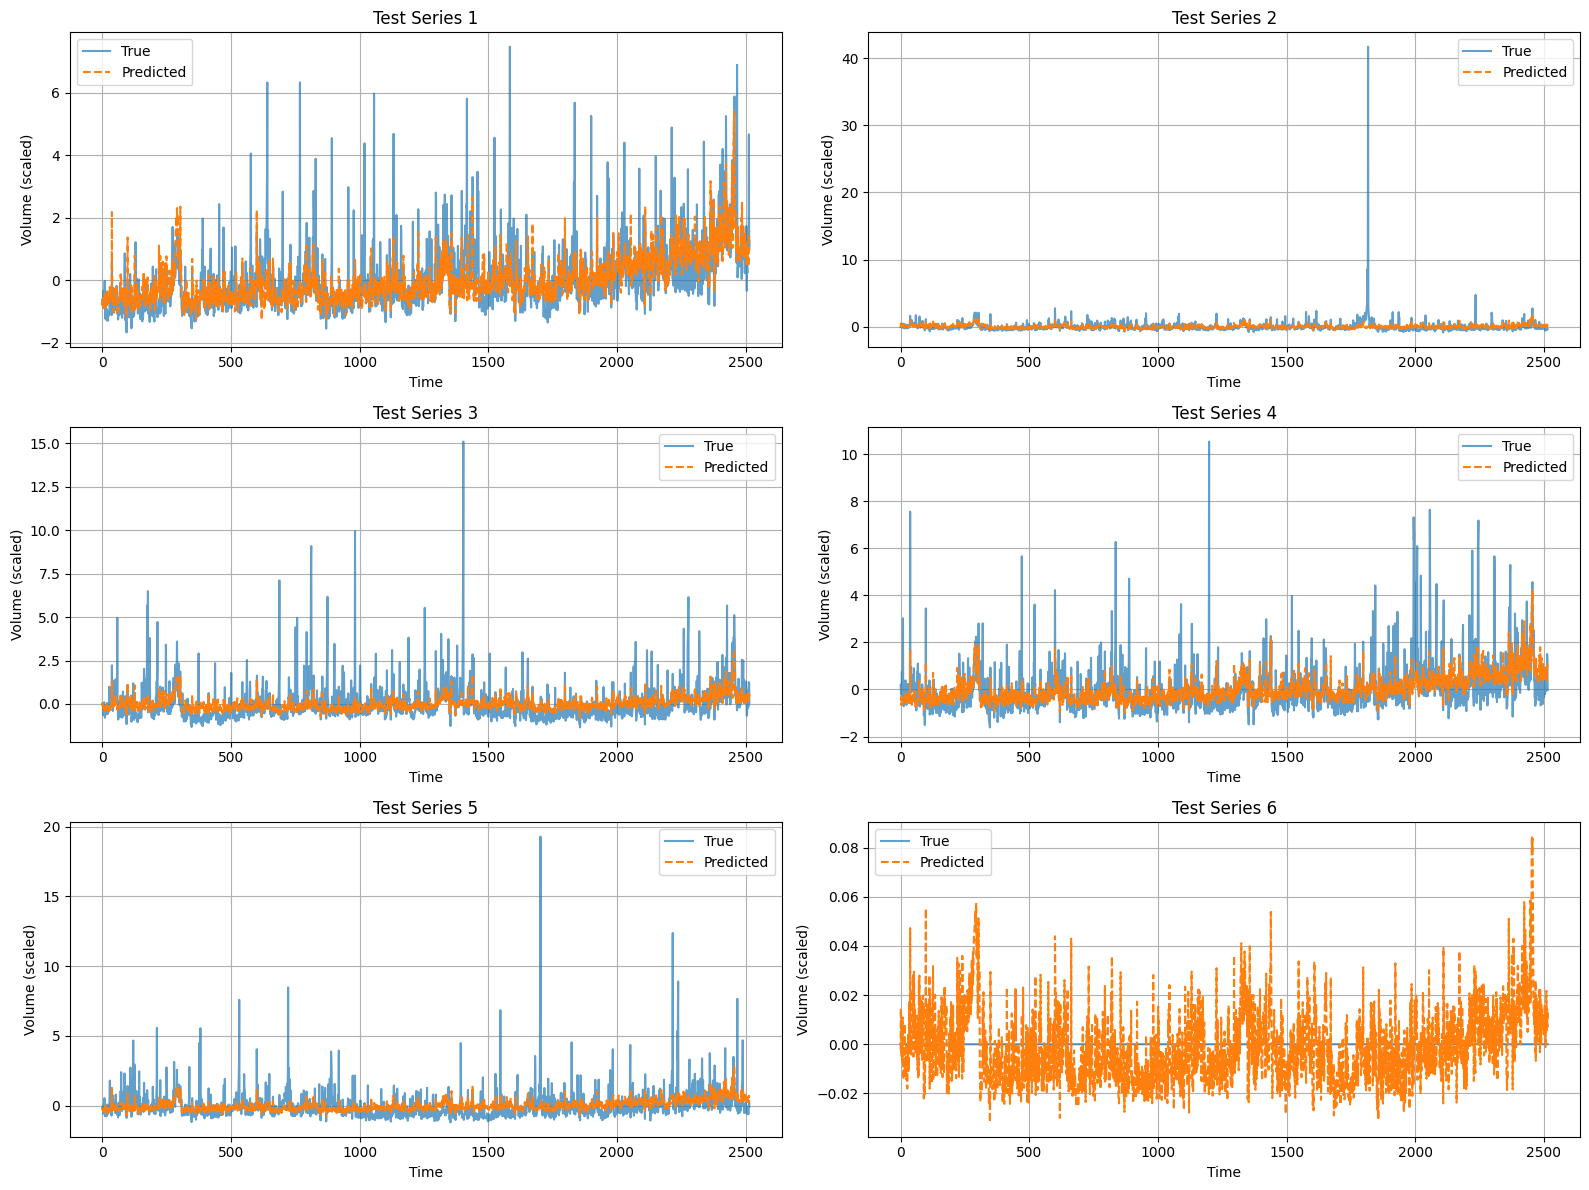

In [28]:
# Load best model weights (if not already loaded)
model.load_weights('best_model.h5')

# Predict on X_test
predictions = model.predict(X_test)

num_test_series = X_test.shape[0]
cols = 2
rows = math.ceil(num_test_series / cols)

plt.figure(figsize=(16, 4 * rows))

for i in range(num_test_series):
    plt.subplot(rows, cols, i + 1)
    plt.plot(y_test[i], label='True', alpha=0.7)
    plt.plot(predictions[i], label='Predicted', linestyle='dashed')
    plt.title(f'Test Series {i + 1}')
    plt.xlabel("Time")
    plt.ylabel("Volume (scaled)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


**Figure 5:**
The plot for actual scaled time series in test set vs their predictions by the auto-encoder. While the auto-encoder is efficiently capaturing the important features of the curves, it struggles identifying the outliers, which is expected.